# Cross-validations across steps

In [1]:
import qiime2 as q2
import pandas as pd
from qiime2.plugins import rescript, taxa as q2t
import tempfile
from glob import glob
import seaborn as sns
from matplotlib import pyplot as plt
import itertools
from re import sub
import warnings
import os

import rescript as rpt

%matplotlib inline

In [2]:
os.chdir('/Users/robesonmichael/Documents/tmp/rescript-release/silva-steps')
os.getcwd()

'/Users/robesonmichael/Documents/tmp/rescript-release/silva-steps'

## Evaluate Classifications

In [44]:
!qiime rescript evaluate-classifications \
    --i-expected-taxonomies \
                silva-nr99-default-noeuks-noeuks-taxa.qza \
                silva-nr99-default-noeuks-culled-taxa.qza \
                silva-nr99-default-noeuks-filt-taxa.qza \
                silva-nr99-default-noeuks-derep-taxa.qza \
                silva-nr99-default-noeuks-derep-taxa-gl.qza \
    --i-observed-taxonomies \
                silva-nr99-default-noeuks-noeuks-taxa-efc-obstax.qza \
                silva-nr99-default-noeuks-culled-taxa-efc-obstax.qza \
                silva-nr99-default-noeuks-filt-taxa-efc-obstax.qza \
                silva-nr99-default-noeuks-derep-taxa-efc-obstax.qza \
                silva-nr99-default-noeuks-derep-taxa-gl-efc-obstax.qza \
     --p-labels 'Base' 'Culled' 'LengFiltByTax' 'DereplicateUniq' 'NoAmbigLabels' \
    --o-evaluation eval-classifications-steps.qzv

Saved Visualization to: eval-classifications-steps.qzv


In [65]:
!qiime rescript evaluate-classifications \
    --i-expected-taxonomies \
                silva-nr99-default-noeuks-noeuks-taxa-ecv-exptax.qza \
                silva-nr99-default-noeuks-culled-taxa-ecv-exptax.qza \
                silva-nr99-default-noeuks-filt-taxa-ecv-exptax.qza \
                silva-nr99-default-noeuks-derep-taxa-ecv-exptax.qza \
                silva-nr99-default-noeuks-derep-taxa-gl-ecv-exptax.qza \
    --i-observed-taxonomies \
                silva-nr99-default-noeuks-noeuks-taxa-ecv-obstax.qza \
                silva-nr99-default-noeuks-culled-taxa-ecv-obstax.qza \
                silva-nr99-default-noeuks-filt-taxa-ecv-obstax.qza \
                silva-nr99-default-noeuks-derep-taxa-ecv-obstax.qza \
                silva-nr99-default-noeuks-derep-taxa-gl-ecv-obstax.qza \
    --p-labels 'Base' 'Culled' 'LengFiltByTax' 'DereplicateUniq' 'NoAmbigLabels' \
    --o-evaluation eval-classifications-steps-ecv.qzv

Saved Visualization to: eval-classifications-steps-ecv.qzv


## Make pretty plot w/ EFC and ECV F-measures

In [3]:
fig_data = dict()
with tempfile.TemporaryDirectory() as temp_dir_name:
    files = glob('NR99-proc-steps-evaltax*') 
    #files = glob('*ecv*.qzv') 
    files += ['eval-classifications-steps.qzv', 'eval-classifications-steps-ecv.qzv']
    for f in files:
        name = f.split('/')[-1].split('.qzv')[0]
        f = q2.Visualization.load(f)
        f.export_data(temp_dir_name)
        fig_data[name] = q2.Metadata.load(temp_dir_name + '/data.tsv').to_dataframe()

In [4]:
fig_data.keys()

dict_keys(['NR99-proc-steps-evaltax', 'eval-classifications-steps', 'eval-classifications-steps-ecv'])

***AXES***
***DAT***
     Level  Unique Labels  Taxonomic Entropy  \
id                                            
1     1.0            2.0           0.183800   
2     2.0          106.0           2.311949   
3     3.0          288.0           3.085972   
4     4.0          762.0           4.694616   
5     5.0         1409.0           5.549462   
6     6.0         4913.0           6.761175   
7     7.0        48013.0           8.546224   
8     1.0            2.0           0.183340   
9     2.0          106.0           2.302813   
10    3.0          287.0           3.070145   
11    4.0          761.0           4.687350   
12    5.0         1406.0           5.544675   
13    6.0         4893.0           6.767222   
14    7.0        45642.0           8.519322   
15    1.0            2.0           0.183340   
16    2.0          106.0           2.302813   
17    3.0          287.0           3.070145   
18    4.0          761.0           4.687350   
19    5.0         1406.0           5.5

35    7.0   0.660033  0.381439   0.483474    NoAmbigLabels


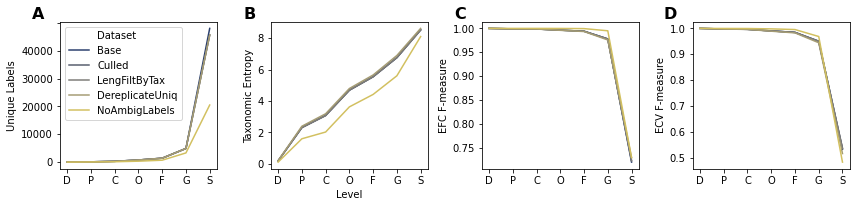

In [5]:
db_labels = ['Base', 'Culled', 'LengFiltByTax', 'DereplicateUniq', 'NoAmbigLabels']
plot_keys = ['NR99-proc-steps-evaltax',
             'NR99-proc-steps-evaltax',
             #'NR99-proc-steps-evaltax',
             'eval-classifications-steps',
             'eval-classifications-steps-ecv']
signals = ['Unique Labels',
           'Taxonomic Entropy',
           #'Proportion of Features Unclassified at Depth',
           'F-Measure',
           'F-Measure']
labels = list('ABCDEF')

fig, axes = plt.subplots(1, 4, figsize=(12, 3), sharex=False)
#fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=False)
axes = axes.flatten()
print('***AXES***\n', axes)
for ax, key, signal, label in zip(axes, plot_keys, signals, labels):
    #print(ax, key, signal, label)
    ax.text(-0.1, 1.1, label, transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top', ha='right')
    dat = fig_data[key].copy()
    print("***DAT***\n", dat)
    #dat.loc[:, 'Dataset'] = dat.loc[:, 'Dataset'].replace(relabels)
    dat = dat[dat['Dataset'] != 'drop']
    dat['Level'] = dat['Level'].replace({
        1: 'D', 2: 'P', 3: 'C', 4: 'O',
        5: 'F', 6: 'G', 7: 'S'})
    if ax == axes[0]:
        legend = 'brief'
        plt.setp(ax.get_yticklabels()[-0], visible=False)
    else:
        legend = False
    #if ax == axes[-1]:
    #    dat = dat[dat['Dataset'].isin([
    #        'GG_noCV', 'SILVA_noCV', 'GTDB_noCV', 'NCBI_noCV'])]
    #    dat['Dataset'] = dat['Dataset'].replace({
    #        'GG_noCV': 'greengenes_99', 'SILVA_noCV': 'silva_99',
    #        'GTDB_noCV': 'GTDB', 'NCBI_noCV': 'NCBI-RefSeq'})
    g = sns.lineplot(x='Level', y=signal, hue='Dataset', data=dat, ax=ax,
                     legend=legend, palette='cividis', sort=False,
                     hue_order=db_labels)
    if ax == axes[3]:
        ax.set_ylabel('ECV F-measure')
    if ax == axes[2]:
        ax.set_ylabel('EFC F-measure')
    if ax != axes[1]:
        ax.set_xlabel('')
fig.tight_layout()
#fig.savefig('steps_taxonomy_evaluation.pdf', bbox_inches='tight')

In [6]:
fig.savefig('steps_taxonomy_evaluation.pdf', bbox_inches='tight')